# Temperature Corrections for MPS and GS3
#### Using In-Situ Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
matplotlib.style.use('grayscale')
%matplotlib notebook

In [3]:
def from_saved():
    filepath = 'C:\\Users\\Alton\\Dropbox (DDI)\\BYU Turf Grass Monitoring Project\\BYU sensor data\\recent data\\'
    df = pd.read_excel(filepath + 'Turf Grass All to 2016-Jun-24.xls')
    return df

In [4]:
df = from_saved()
df = df.replace('***',np.nan)

With our packages imported and our sensor data loaded, we are ready to begin.
Let's start off by selecting just the MPS sensor data from our dataset.  

Since MPS sensors are measuring the ceramic discs, it does not matter what kind of soil they are placed in. They can reliably measure the matric water potential as long as they have good soil contact. However, they have an immense sensitivity to temperature fluctuations in the lower (more negative) ranges of water potential. This can be observed at around -500 kPa, but is even more extreme below -1000 kPa. We'll use the data from all 8 of the available MPS sensors to create a temperature correction algorithm.

In [5]:
mps_mask = ['MPS' in x for x in df]
mps_data = df[df.columns[mps_mask]]
mps_data = mps_data.dropna()

In [6]:
temps_mask = ['Temp' in x for x in mps_data]
mps_temps = mps_data[mps_data.columns[temps_mask]]

potentials_mask = ['kPa' in x for x in mps_data]
mps_potentials = mps_data[mps_data.columns[potentials_mask]]

<IPython.core.display.Javascript object>


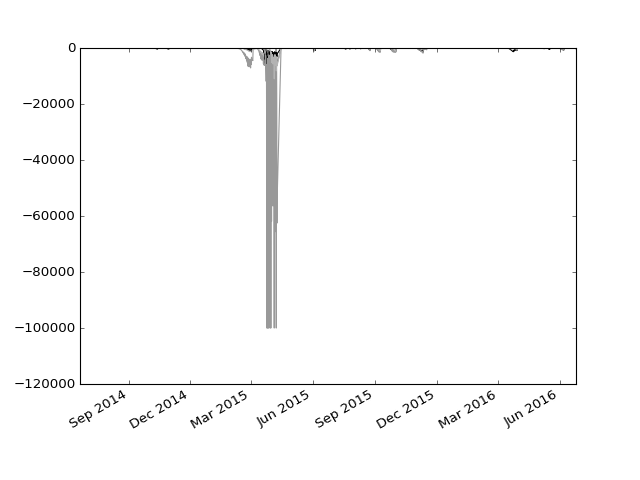

<IPython.core.display.Javascript object>


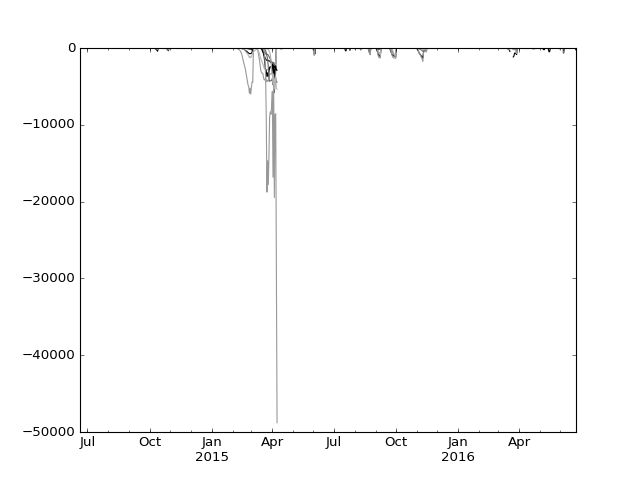

In [7]:
mps_potentials.plot(style='-',legend=False)
mps_potentials.resample('D').median().plot(legend=False)

With our data selected, and with a decent idea of what it looks like, let's outline what we're about to do.  
- Eliminate inappropriate data.  
To do this, it will be necessary to identify days on which the measured water potential changed too much due to actual changes in water potential, and not due to temperature fluctuations. It will also be important to remove any empty measurements.  

- Calculate $\frac{\delta\Psi}{\delta T}$ for each valid measurement.
- Plot all of the slopes against the mean value of $\Psi$ for that day.
- Fit a curve to the scatter plot to obtain an equation for $\frac{\delta\Psi}{\delta T}$ based on $\Psi$.


In [16]:
nw6=df[['NW MPS-2 6cm Water Potential kPa','NW MPS-2 6cm Temp °C']].dropna()
ne6=df[['NE MPS-2 6cm Water Potential kPa','NE MPS-2 6cm Temp °C']].dropna()
sw6=df[['SW MPS-2 6cm Water Potential kPa','SW MPS-2 6cm Temp °C']].dropna()
se6=df[['SE MPS-2 6cm Water Potential kPa','SE MPS-2 6cm Temp °C']].dropna()
nw15=df[['NW MPS-2 15cm Water Potential kPa','NW MPS-2 15cm Temp °C']].dropna()
ne15=df[['NE MPS-2 15cm Water Potential kPa','NE MPS-2 15cm Temp °C']].dropna()
sw15=df[['SW MPS-2 15cm Water Potential kPa','SW MPS-2 15cm Temp °C']].dropna()
se15=df[['SE MPS-2 15cm Water Potential kPa','SE MPS-2 15cm Temp °C']].dropna()

for x in [nw6,ne6,sw6,se6,nw15,ne15,sw15,se15]:
    x.columns = ['Potential','Temp']
    x['dPsi/dT'] = x.Potential.diff()/x.Temp.diff()
    
nw6=nw6.replace([np.inf,-np.inf],np.nan).dropna()
ne6=ne6.replace([np.inf,-np.inf],np.nan).dropna()
sw6=sw6.replace([np.inf,-np.inf],np.nan).dropna()
se6=se6.replace([np.inf,-np.inf],np.nan).dropna()
nw15=nw15.replace([np.inf,-np.inf],np.nan).dropna()
ne15=ne15.replace([np.inf,-np.inf],np.nan).dropna()
sw15=sw15.replace([np.inf,-np.inf],np.nan).dropna()
se15=se15.replace([np.inf,-np.inf],np.nan).dropna()


nw6.name = 'Northwest 6cm MPS sensor'
ne6.name = 'Northeast 6cm MPS sensor'
sw6.name = 'Southwest 6cm MPS sensor'
se6.name = 'Southeast 6cm MPS sensor'
nw15.name = 'Northwest 15cm MPS sensor'
ne15.name = 'Northeast 15cm MPS sensor'
sw15.name = 'Southwest 15cm MPS sensor'
se15.name = 'Southeast 15cm MPS sensor'

In [17]:
all_mps_daily_dfs = []
#all_mps_daily_dfs_mins = []
for x in [nw6,ne6,sw6,se6,nw15,ne15,sw15,se15]:
    ##The most negative value divided by the least negative to check if it is too steep, and avoid frozen conditions
    mask = ((x.Potential.resample('2D').min()/x.Potential.resample('2D').max()) <= 5) & (x.Temp.resample('2D').min() >= 3)
    ##The date range is restricted to a given event.
    #mask = mask & (x.resample('D').mean().index > '2015-03-09') & (x.resample('D').mean().index < '2015-04-09')
    
    all_mps_daily_dfs.append(x.resample('2D').mean()[mask])
    #all_mps_daily_dfs_mins.append(x.resample('3H').min().resample('2D').mean()[mask])
all_mps = pd.concat(all_mps_daily_dfs)
#all_mins = pd.concat(all_mps_daily_dfs_mins)
#all_mps['dPsi/dT']=all_mins['dPsi/dT']

In [18]:
##print(popts) #[  4.72597434e-10   2.41460939e-05  -1.39768492e-01]

small = all_mps['Potential']>-20000
notbig = all_mps['Potential']>=-500
at_22 = (all_mps['Temp'] <= 25)&(all_mps['Temp']>=20)

<IPython.core.display.Javascript object>


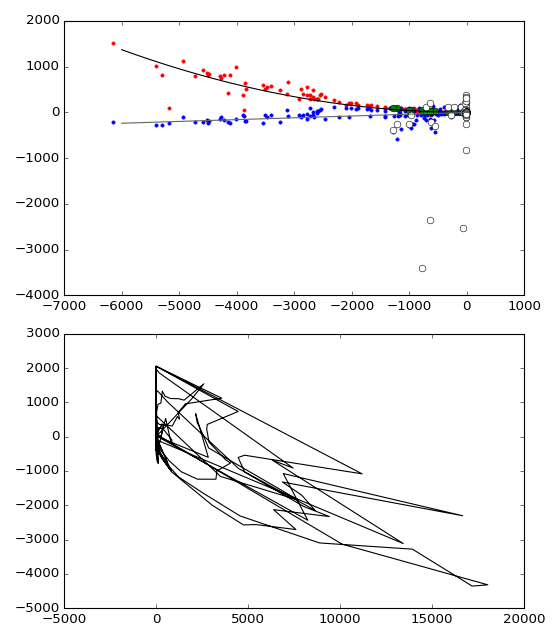

In [20]:
fig = plt.figure(num=3,figsize=(7,8))
ax1 = fig.add_subplot(211)
#ax1.loglog()
ax1.plot(all_mps[small]['Potential'],all_mps[small]['dPsi/dT'],'r.')
ax1.plot(all_mps[small]['Potential'],(all_mps[small]['Potential']-all_mps[small]['Potential'].resample('D').mean().resample('30T').pad()[all_mps[small].index])/(22-all_mps[small]['Temp']),'b.')

ax1.plot(all_mps[at_22]['Potential'],all_mps[at_22]['dPsi/dT'],'go')
ax1.plot(all_mps[at_22]['Potential'],(all_mps[at_22]['Potential']-all_mps[at_22]['Potential'].resample('D').mean().resample('30T').pad()[all_mps[at_22].index])/(22-all_mps[at_22]['Temp']),'wo')

def mpspiecewise(x,k1,k2,k3):
    x0=0
    x1=0
    x2=-500
    x3=-2000
    x4=-20000
    return np.piecewise(x,condlist=[(x1>x)&(x>=x2),(x2>x)&(x>=x3),(x3>x)&(x>=x4)],
                        funclist=[lambda x:k1*(x-x1),
                                  lambda x:k2*(x-x2)+k1*(x-x1),
                                  lambda x:k3*(x-x3)+k2*(x-x2)+k1*(x-x1),
                                  lambda x:x0])

def mps_parabolic(x,a):
    return a*x**2
def mps_sqrt(M,G,T,Tref,a):
    return -np.sqrt(np.abs((M-G)/(T-Tref)))/np.sqrt(a)

def mps_lin(M,G,T,Tref,a):
    return ((M-G)/(T-Tref))/a
def mps_linear(x,a):
    return a*x


popts,pcovs = optimize.curve_fit(f=mps_parabolic,
                                 xdata=all_mps[small].dropna()['Potential'].values,
                                 ydata=all_mps[small].dropna()['dPsi/dT'].values)

migt = (all_mps[small].dropna()['Potential']-all_mps[small].dropna()['Potential'].resample('D').mean().resample('30T').pad()[all_mps[small].dropna().index])/(22-all_mps[small]['Temp'])
migt = migt.replace([np.inf,-np.inf],np.nan)
migt = migt.dropna()
cliptomigt = [x  in migt.index for x in all_mps.index]
qopts,qcovs = optimize.curve_fit(f=mps_linear,
                                 xdata=all_mps[cliptomigt]['Potential'],
                                 ydata=migt)

#print(popts)
psi = np.linspace(-6000,25,300)
delta = mps_parabolic(psi,*popts)
ax1.plot(psi,delta)
ax1.plot(psi,mps_linear(psi,*qopts))

#bopts = [-200/10000,0]
#delta = mpspiecewise(psi,*bopts)
#ax1.plot(psi,delta)

ax2 = fig.add_subplot(212)
ax2.plot(mps_parabolic(all_mps[small]['Potential'],*popts)*(22-all_mps[small]['Temp']),all_mps[small]['Potential']-all_mps[small]['Potential'].resample('D').mean().resample('30T').pad()[all_mps[small].index],'-')
fig.tight_layout()
#print(psi)
#print(delta)

In [67]:
len(migt)

2461

In [64]:
popts


array([  3.80887002e-05])

<IPython.core.display.Javascript object>


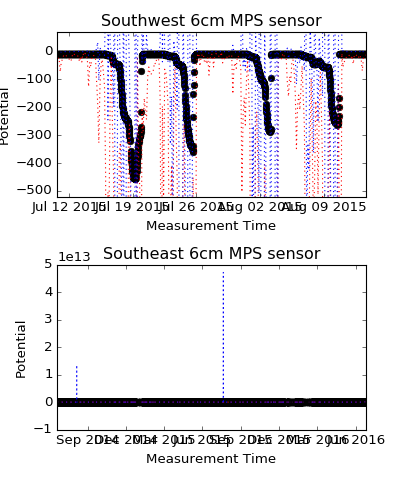

In [21]:

num = 0
allsensors = [sw6,se6] #[nw6,ne6,  ,nw15,ne15,sw15,se15]
count = len(allsensors)
rows = np.ceil(np.sqrt(count))

if rows == count: 
    cols = 1
else:
    cols = rows

fig = plt.figure(num=4,figsize=(5*cols,3*rows))
for location in allsensors:
    num += 1
    ax = fig.add_subplot(rows,cols,num,title=location.name,xlabel='Measurement Time',ylabel='Potential')
    ax.plot(location.index,location.Potential,'o')
    M = location.Potential.resample('3H').mean()
    G = location.Potential.resample('D').mean().resample('3H').pad()[M.index]
    T = location.Temp.resample('3H').mean()
    Tref = 22
    ax.plot(M.index,mps_sqrt(M,G,T,Tref,*popts),':r')
    #ax.plot(location.index,location.Temp,'.-')
    #ax.plot(location.index,location.Potential + mpspiecewise(location.Potential,*bopts)*-(location.Temp-22),':m')
    ax.plot(M.index,mps_lin(M,G,T,Tref,*qopts),':b')
    
fig.tight_layout()
#ax = fig.add_subplot(111,title=se6.name,xlabel='Measurement Time',ylabel='Potential')
#ax.plot(se6.index,se6.Potential,'-')
#ax.plot(se6.index,mpspiecewise(se6.Potential,*popts)*(se6.Temp-22),':r')
#ax.set_xbound('2015-09-01','2015-10-05')
#ax.set_ybound(-2000,0)
